In [1]:
import os
import time
import glob
import pickle
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.special import expit
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from baseline import *

In [2]:
seed = 1
device = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device=="cuda":
    torch.cuda.manual_seed(seed)

## Prepare Dataset

In [3]:
lp_train = pickle.load(open('data/cora/lp_train.pkl', 'rb'))
lp_test = pickle.load(open('data/cora/lp_test.pkl', 'rb'))

node_features = pickle.load(open('data/cora/node_features.pkl', 'rb'))
text_features = node_features.toarray()
nnodes = text_features.shape[0]

pca = PCA(n_components=100)
pca.fit(text_features)
emb_features = pca.transform(text_features)
emb_features = torch.from_numpy(emb_features).to(device).float()
    
adjs = defaultdict(set)
for node in list(lp_train.nodes()):
    adjs[node] = adjs[node].union(lp_train[node])
adjs = [np.sort(list(v)) for k,v in adjs.items()]

## Parameters

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

nlayer = 1
dims = [100]*(nlayer+1)
dropout = 0.4

lr = 0.005
weight_decay = 0.0005

patience = 50
nepoch = 10000

## Link Prediction Supervised Training

In [5]:
# posi, nega = [], []
# for node in range(nnodes):
#     neighbors = list(lp_train[node])
#     nega_neighbors = random.sample(list(set(range(nnodes)).difference(set(neighbors))), 5)
#     nega.append(np.stack(([node]*len(nega_neighbors), nega_neighbors), axis=-1))
#     posi.append(np.stack(([node]*len(neighbors), neighbors), axis=-1))
# posi = np.concatenate(posi, axis=0)
# nega = np.concatenate(nega, axis=0)

# X_train = np.concatenate([posi,nega], axis=0)
# y_train = torch.from_numpy(np.concatenate([[1]*len(posi), [0]*len(nega)])).float().to(device)
# X_test = lp_test[:,:-1]
# y_test = torch.from_numpy(lp_test[:,-1]).float().to(device)

In [6]:
X_train, y_train, X_test, y_test = pickle.load(open('simulation/train_test.pkl', 'rb'))
y_train = torch.from_numpy(y_train).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

## Train & Test

In [7]:
def evaluate(cos_sim, labels):
    pred = expit(cos_sim)>0.5
    f1, accuracy = f1_score(labels, pred), accuracy_score(labels, pred)
    return accuracy, f1

In [8]:
pdist = nn.PairwiseDistance()
edges = np.array(list(lp_train.edges()))

def edge_diff(embeds):
    diff = pdist(embeds[edges[:,0]], embeds[edges[:,1]])
    return torch.mean(diff).cpu().item()

def embed_diff(embeds, prev_embeds):
    diff = pdist(embeds, prev_embeds)
    return torch.mean(diff).cpu().item()

In [9]:
cos = nn.CosineSimilarity()

def sup_train(model, optimizer, epoch, prev_embeds):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    
    real_adjs = []
    for node, neighbors in enumerate(adjs):
        real_neighbors = list(neighbors)
        real_neighbors.append(node)
        real_adjs.append(real_neighbors)
    
    embeds = model(emb_features, real_adjs)
    lp_input = torch.stack([embeds[X_train[:,0]], embeds[X_train[:,1]]])
    similarity = cos(lp_input[0], lp_input[1])
    loss = F.binary_cross_entropy_with_logits(similarity, y_train)
    
    accuracy, f1 = evaluate(similarity.detach().cpu().numpy(), y_train.cpu().numpy())
    curr_edge_diff = edge_diff(embeds)
    curr_embed_diff = embed_diff(embeds, prev_embeds)
    curr_input_diff = embed_diff(embeds, emb_features)
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1)%1==0:
        print('Epoch: {} || Loss: {:.4f}, Acc: {:.4f}, F1: {:.4f} || Edge_diff: {:.4f}, Embed_diff: {:.4f}, Input_diff: {:.4f} || Time: {:.4f}s'
              .format(epoch, loss.item(), accuracy, f1, curr_edge_diff, curr_embed_diff, curr_input_diff, time.time()-t))
    
    return loss.item(), curr_edge_diff, curr_embed_diff, curr_input_diff, embeds

In [10]:
def sup_test(model):
    model.eval()
    
    real_adjs = []
    for node, neighbors in enumerate(adjs):
        real_neighbors = list(neighbors)
        real_neighbors.append(node)
        real_adjs.append(real_neighbors)
    
    embeds = model(emb_features, real_adjs)
    lp_input = torch.stack([embeds[X_test[:,0]], embeds[X_test[:,1]]])
    similarity = cos(lp_input[0], lp_input[1])
    loss = F.binary_cross_entropy_with_logits(similarity, y_test)
    
    accuracy, f1 = evaluate(similarity.detach().cpu().numpy(), y_test.cpu().numpy())
    
    print('Loss: {:.4f}, Acc: {:.4f}, F1: {:.4f}'.format(loss.item(), accuracy, f1))

In [11]:
t_total = time.time()

model = GraphSAGEModel(dims=dims, dropout=dropout, nlayer=nlayer, device=device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

prev_embeds = emb_features
loss_values, edge_diffs, embed_diffs, input_diffs = [], [], [], []
bad_counter, best, best_epoch = 0, nepoch+1, 0
for epoch in range(nepoch):
    loss_value, curr_edge_diff, curr_embed_diff, curr_input_diff, prev_embeds = sup_train(model, optimizer, epoch, prev_embeds)
    
    loss_values.append(loss_value)
    edge_diffs.append(curr_edge_diff)
    embed_diffs.append(curr_embed_diff)
    input_diffs.append(curr_input_diff)
    
    torch.save(model.state_dict(), 'model/Supervised/{}.pkl'.format(epoch))
    
    if loss_values[-1] < best:
        best, best_epoch, bad_counter = loss_values[-1], epoch, 0
    else:
        bad_counter += 1
                
    if bad_counter == patience:
        break
        
    files = glob.glob('model/Supervised/*.pkl')
    for file in files:
        epoch_nb = int(file.split('.')[0].split('/')[-1])
        if epoch_nb < best_epoch:
            os.remove(file) 
    
files = glob.glob('model/Supervised/*.pkl')
for file in files:
    epoch_nb = int(file.split('.')[0].split('/')[-1])
    if epoch_nb > best_epoch:
        os.remove(file) 
        
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

print('Loading {}th epoch'.format(best_epoch))
model.load_state_dict(torch.load('model/Supervised/{}.pkl'.format(best_epoch)))

sup_test(model)

Epoch: 0 || Loss: 0.6921, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.7459, Embed_diff: 1.0150, Input_diff: 1.0150 || Time: 0.6491s
Epoch: 1 || Loss: 0.6887, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.7338, Embed_diff: 0.7053, Input_diff: 1.0146 || Time: 0.4945s
Epoch: 2 || Loss: 0.6846, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.7099, Embed_diff: 0.6993, Input_diff: 1.0146 || Time: 0.6038s
Epoch: 3 || Loss: 0.6808, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.7045, Embed_diff: 0.6783, Input_diff: 1.0142 || Time: 0.7559s
Epoch: 4 || Loss: 0.6779, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.6948, Embed_diff: 0.6699, Input_diff: 1.0144 || Time: 0.6274s
Epoch: 5 || Loss: 0.6741, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.6758, Embed_diff: 0.6679, Input_diff: 1.0144 || Time: 0.8027s
Epoch: 6 || Loss: 0.6702, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.6599, Embed_diff: 0.6397, Input_diff: 1.0140 || Time: 0.5992s
Epoch: 7 || Loss: 0.6684, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.6567, Embed_diff: 0.6363, Input_diff: 

Epoch: 64 || Loss: 0.6264, Acc: 0.3977, F1: 0.5624 || Edge_diff: 0.5354, Embed_diff: 0.4918, Input_diff: 1.0149 || Time: 0.4171s
Epoch: 65 || Loss: 0.6278, Acc: 0.3952, F1: 0.5614 || Edge_diff: 0.5451, Embed_diff: 0.5014, Input_diff: 1.0149 || Time: 0.4164s
Epoch: 66 || Loss: 0.6250, Acc: 0.3981, F1: 0.5625 || Edge_diff: 0.5355, Embed_diff: 0.4995, Input_diff: 1.0149 || Time: 0.4169s
Epoch: 67 || Loss: 0.6267, Acc: 0.3951, F1: 0.5614 || Edge_diff: 0.5388, Embed_diff: 0.4986, Input_diff: 1.0148 || Time: 0.4042s
Epoch: 68 || Loss: 0.6253, Acc: 0.3955, F1: 0.5616 || Edge_diff: 0.5398, Embed_diff: 0.4950, Input_diff: 1.0151 || Time: 0.3508s
Epoch: 69 || Loss: 0.6251, Acc: 0.3969, F1: 0.5621 || Edge_diff: 0.5371, Embed_diff: 0.4985, Input_diff: 1.0150 || Time: 0.4439s
Epoch: 70 || Loss: 0.6239, Acc: 0.3996, F1: 0.5632 || Edge_diff: 0.5338, Embed_diff: 0.4900, Input_diff: 1.0149 || Time: 0.7528s
Epoch: 71 || Loss: 0.6278, Acc: 0.3950, F1: 0.5612 || Edge_diff: 0.5450, Embed_diff: 0.5028, Inpu

Epoch: 128 || Loss: 0.6254, Acc: 0.4002, F1: 0.5634 || Edge_diff: 0.5422, Embed_diff: 0.5119, Input_diff: 1.0162 || Time: 0.4156s
Epoch: 129 || Loss: 0.6247, Acc: 0.3981, F1: 0.5626 || Edge_diff: 0.5411, Embed_diff: 0.5004, Input_diff: 1.0158 || Time: 0.4170s
Epoch: 130 || Loss: 0.6266, Acc: 0.3969, F1: 0.5620 || Edge_diff: 0.5455, Embed_diff: 0.4998, Input_diff: 1.0158 || Time: 0.4165s
Epoch: 131 || Loss: 0.6261, Acc: 0.3974, F1: 0.5623 || Edge_diff: 0.5511, Embed_diff: 0.5072, Input_diff: 1.0160 || Time: 0.4217s
Epoch: 132 || Loss: 0.6251, Acc: 0.4017, F1: 0.5640 || Edge_diff: 0.5444, Embed_diff: 0.5010, Input_diff: 1.0158 || Time: 0.4281s
Epoch: 133 || Loss: 0.6255, Acc: 0.3998, F1: 0.5633 || Edge_diff: 0.5405, Embed_diff: 0.4991, Input_diff: 1.0161 || Time: 0.4183s
Epoch: 134 || Loss: 0.6241, Acc: 0.3975, F1: 0.5624 || Edge_diff: 0.5421, Embed_diff: 0.4955, Input_diff: 1.0160 || Time: 0.4184s
Epoch: 135 || Loss: 0.6262, Acc: 0.3963, F1: 0.5618 || Edge_diff: 0.5432, Embed_diff: 0.49

Epoch: 192 || Loss: 0.6265, Acc: 0.4011, F1: 0.5638 || Edge_diff: 0.5584, Embed_diff: 0.5160, Input_diff: 1.0161 || Time: 0.6905s
Epoch: 193 || Loss: 0.6238, Acc: 0.4035, F1: 0.5647 || Edge_diff: 0.5433, Embed_diff: 0.4982, Input_diff: 1.0155 || Time: 0.4945s
Epoch: 194 || Loss: 0.6256, Acc: 0.4011, F1: 0.5639 || Edge_diff: 0.5437, Embed_diff: 0.5053, Input_diff: 1.0157 || Time: 0.3709s
Epoch: 195 || Loss: 0.6251, Acc: 0.4003, F1: 0.5635 || Edge_diff: 0.5508, Embed_diff: 0.5010, Input_diff: 1.0158 || Time: 0.4097s
Epoch: 196 || Loss: 0.6255, Acc: 0.3996, F1: 0.5632 || Edge_diff: 0.5499, Embed_diff: 0.4987, Input_diff: 1.0158 || Time: 0.4134s
Epoch: 197 || Loss: 0.6268, Acc: 0.3967, F1: 0.5620 || Edge_diff: 0.5439, Embed_diff: 0.5047, Input_diff: 1.0159 || Time: 0.4128s
Epoch: 198 || Loss: 0.6263, Acc: 0.4000, F1: 0.5634 || Edge_diff: 0.5534, Embed_diff: 0.5064, Input_diff: 1.0159 || Time: 0.4087s
Epoch: 199 || Loss: 0.6261, Acc: 0.3970, F1: 0.5622 || Edge_diff: 0.5486, Embed_diff: 0.51

Text(0.5, 1.0, 'Training Loss Curve')

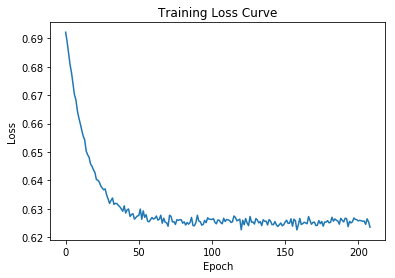

In [12]:
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')

Text(0.5, 1.0, 'Training Edge-wise Distance Curve')

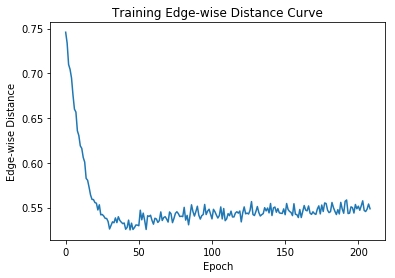

In [13]:
plt.plot(edge_diffs)
plt.xlabel('Epoch')
plt.ylabel('Edge-wise Distance')
plt.title('Training Edge-wise Distance Curve')

Text(0.5, 1.0, 'Change in Embedding Curve')

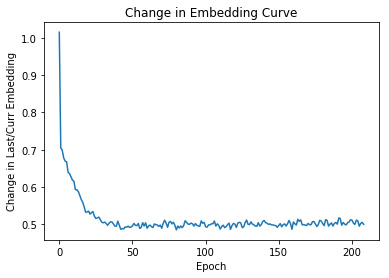

In [14]:
plt.plot(embed_diffs)
plt.xlabel('Epoch')
plt.ylabel('Change in Last/Curr Embedding')
plt.title('Change in Embedding Curve')

Text(0.5, 1.0, 'Change in Input/Output Curve')

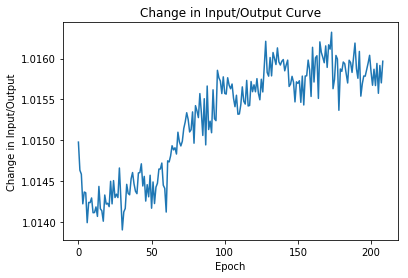

In [15]:
plt.plot(input_diffs)
plt.xlabel('Epoch')
plt.ylabel('Change in Input/Output')
plt.title('Change in Input/Output Curve')